# Data Augmentation

In [1]:
import urllib

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_datasets as tfds
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np

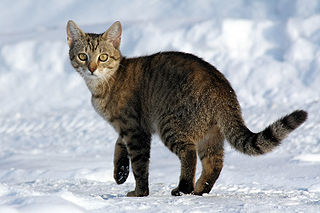

In [2]:
image_path = tf.keras.utils.get_file("cat.jpg", "https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg")
PIL.Image.open(image_path)

In [3]:
image_string = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image_string, channels = 3)
image

<tf.Tensor: shape=(213, 320, 3), dtype=uint8, numpy=
array([[[194, 206, 218],
        [194, 206, 218],
        [194, 206, 218],
        ...,
        [169, 190, 207],
        [162, 184, 205],
        [158, 180, 204]],

       [[195, 207, 219],
        [195, 207, 219],
        [195, 207, 219],
        ...,
        [170, 191, 208],
        [162, 184, 205],
        [155, 179, 203]],

       [[196, 208, 220],
        [196, 208, 220],
        [196, 208, 220],
        ...,
        [170, 191, 208],
        [161, 183, 206],
        [154, 178, 202]],

       ...,

       [[232, 237, 241],
        [234, 239, 243],
        [236, 241, 245],
        ...,
        [211, 220, 229],
        [213, 222, 229],
        [202, 211, 216]],

       [[234, 239, 242],
        [236, 241, 244],
        [238, 243, 246],
        ...,
        [217, 226, 235],
        [221, 230, 235],
        [212, 221, 226]],

       [[235, 240, 243],
        [237, 242, 245],
        [239, 244, 247],
        ...,
        [221, 230, 23

### A function to visualize and compare the original and augmented image side by side.

In [4]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title('Original image')
    plt.imshow(original)
    
    plt.subplot(1, 2, 2)
    plt.title('Augmented image')
    plt.imshow(augmented)

## Augment a single image

### Flipping the image 

#### flipping the image either vertically or horizontally

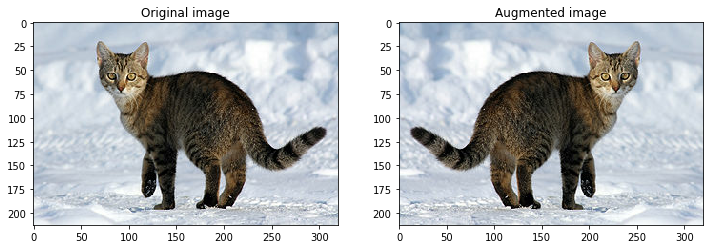

In [5]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

## Grayscale the image

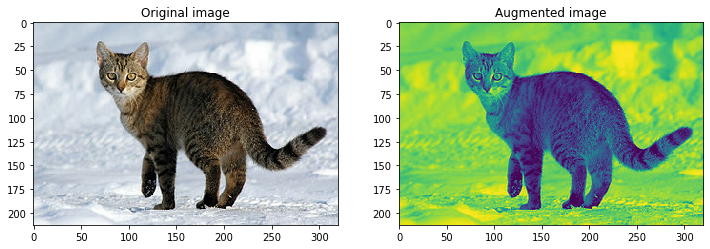

In [6]:
grayscale = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscale))

## Saturate the image

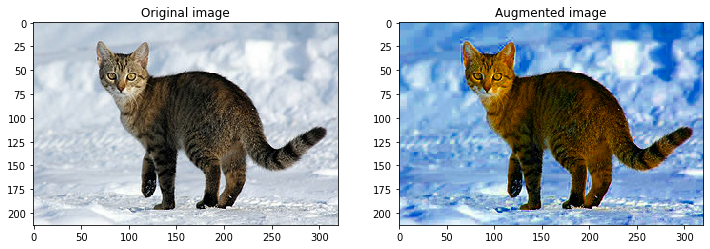

In [7]:
saturated = tf.image.adjust_saturation(image, 5)
visualize(image, saturated)

## Change image brightness

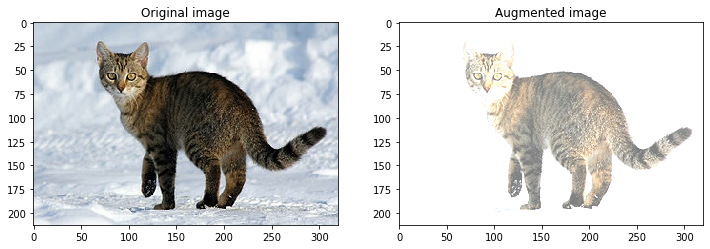

In [8]:
bright = tf.image.adjust_brightness(image, 0.5)
visualize(image, bright)

## Rotate the image

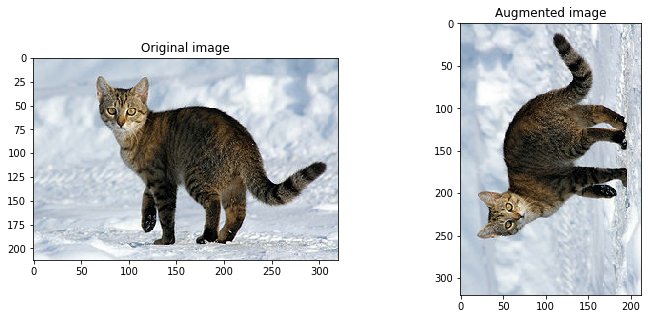

In [9]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

## Center crop the image

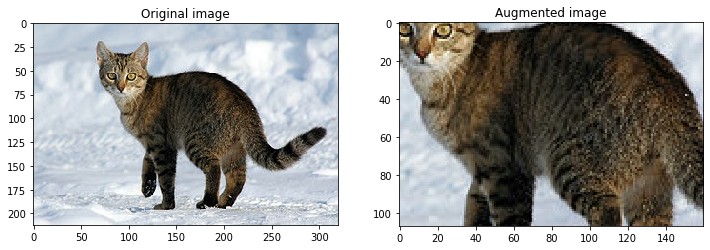

In [10]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

## Augment a dataset and train the model with it

In [5]:
dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples

In [6]:
info

tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    urls=['https://storage.googleapis.com/cvdf-datasets/mnist/'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

In [8]:
def convert(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

In [10]:
def augment(image, label):
    image, label = convert(image, label)
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
    image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    
    return image, label


In [11]:
BATCH_SIZE = 64
# Only use a subset of the data so it's easier to overfit, for this tutorial
NUM_EXAMPLES = 2048

## Created augmented dataset

In [12]:
augmented_train_batches = (
    train_dataset
     # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # The augmentation is added here.
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
    
)

## Non augmented dataset

In [14]:
non_augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # No augmentation.
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [15]:
validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

In [16]:
def model():
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),
        layers.Dense(4096, activation='relu'),
        layers.Dense(4096, activation='relu'),
        layers.Dense(10)
    ])
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [ ]:
model_without_aug = model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs=5, validation_data=validation_batches)

In [19]:
model_with_aug = model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs=5, validation_data = validation_batches)

Epoch 1/5
32/32 [==============================] - 30s 930ms/step - loss: 2.4163 - accuracy: 0.2812 - val_loss: 1.1949 - val_accuracy: 0.6700
Epoch 2/5
32/32 [==============================] - 29s 900ms/step - loss: 1.4697 - accuracy: 0.5132 - val_loss: 0.8655 - val_accuracy: 0.7229
Epoch 3/5
32/32 [==============================] - 29s 919ms/step - loss: 1.1540 - accuracy: 0.6104 - val_loss: 0.5675 - val_accuracy: 0.8560
Epoch 4/5
32/32 [==============================] - 28s 875ms/step - loss: 0.8445 - accuracy: 0.7227 - val_loss: 0.4131 - val_accuracy: 0.8904
Epoch 5/5
32/32 [==============================] - 27s 835ms/step - loss: 0.6782 - accuracy: 0.7910 - val_loss: 0.3492 - val_accuracy: 0.8883
